# Trabalho prático 2 - Regressão

### Davi Segundo - 417153 & Diego Holanda - 411627



## Bibliotecas e módulos utilizados no trabalho

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, GroupKFold
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures

### Funções auxiliares

In [2]:
def show_metrics(results):
    r2 = results["test_r2"].mean()
    squared = results["test_neg_mean_squared_error"].mean()
    print("----------------------")
    print(f"R2_Mean: {r2*100:.2f}%")
    print(f"Mean_Squared_Error_Mean: {-squared}")

### Configuração de plot dos gráficos

In [3]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

## Leitura e preparação dos dados

Link do dataset: [Cars Dataset](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho/)

In [14]:
cars = pd.read_csv('./datasets/car data.csv')
cars = cars.drop(['Car_Name'], axis=1)
cars["Idade"] = 2021 - cars["Year"]
cars = cars.replace({
    'Manual': 0,
    'Automatic': 1,
    'Petrol': 0,
    'Diesel': 1,
    'CNG': 2,
    'Individual': 1,
    'Dealer': 0,
})
cars

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Idade
0,2014,3.35,5.59,27000,0,0,0,0,7
1,2013,4.75,9.54,43000,1,0,0,0,8
2,2017,7.25,9.85,6900,0,0,0,0,4
3,2011,2.85,4.15,5200,0,0,0,0,10
4,2014,4.60,6.87,42450,1,0,0,0,7
...,...,...,...,...,...,...,...,...,...
296,2016,9.50,11.60,33988,1,0,0,0,5
297,2015,4.00,5.90,60000,0,0,0,0,6
298,2009,3.35,11.00,87934,0,0,0,0,12
299,2017,11.50,12.50,9000,1,0,0,0,4


## Análise dos atributos do Dataset

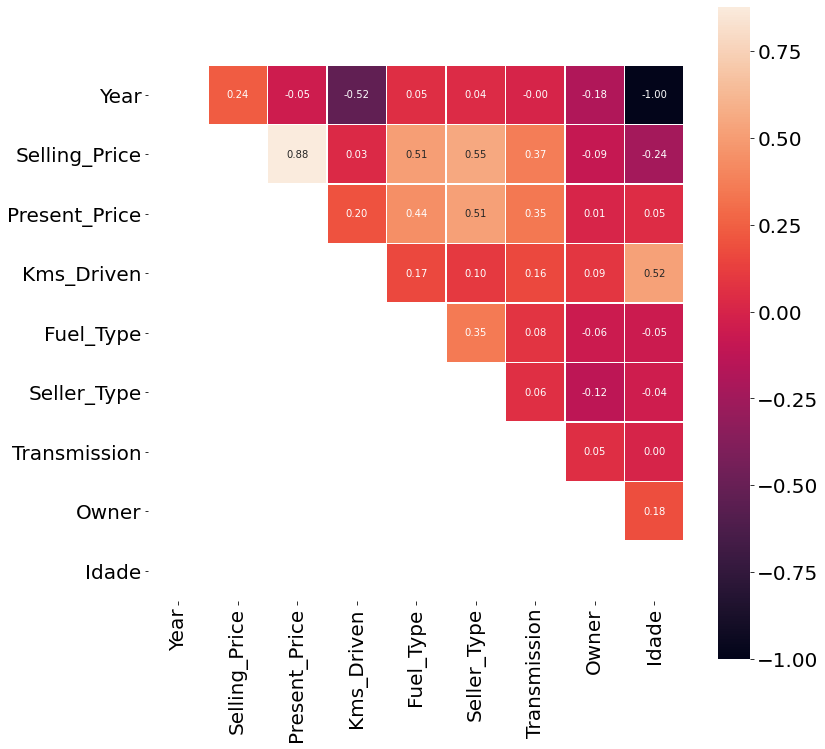

In [5]:
plt.figure(figsize=(12,12))
mask = np.tril(np.ones_like(cars.corr(), dtype=np.bool))
sns.heatmap(cars.corr(), annot=True, fmt='.2f', linewidths='0.5', square=True, mask=mask);

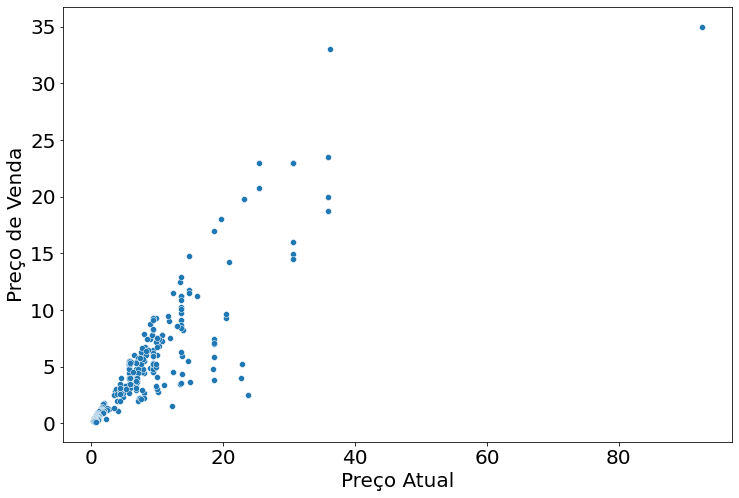

In [6]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=cars.Present_Price, y=cars.Selling_Price)
plt.ylabel('Preço de Venda', size=20)
plt.xlabel('Preço Atual', size=20);

## Separação do conjunto de treino e teste

In [7]:
np.random.seed(888)
train_set, test_set = train_test_split(cars, test_size=.2)

x_train, y_train = train_set.drop(['Selling_Price'], axis=1), train_set.Selling_Price
x_test, y_test = test_set.drop(['Selling_Price'], axis=1), test_set.Selling_Price

## Paramêtros de otimização do GridSearch

In [8]:
linear_parameters = {
    'model__fit_intercept' : [True, False],
}

tree_parameters = {
    'model__criterion' : ['mse', 'friedman_mse', 'mae', 'poisson'],
    'model__max_depth' : [2,3,4,5,8,10,12,15,20]
}

svr_parameters = {
    'model__kernel' : ['linear', 'poly', 'bf', 'sigmoid', 'precomputed'],
    'model__degree' : [1,2,3,4,5,8,10]
}

## Regressão Linear

Regressão linear é um modelo linear para treinamento supervisionado que busca minimizar os erros quadráticos entre as features e as labels. Isso feito encontrando um vetor de pesos $w = [w_1, w_2, \dots, w_n]$ para cada atributo da entrada com objetivo de gerar uma reta (ou curva no caso polinomial) que minimize os erros.

Esses podem ser encontrados de maneira iterativa usado o SGDRegressor ou de maneira analítica com o Linear Regression.

In [9]:
model = LinearRegression()

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model)
])

parameters = linear_parameters

grid = GridSearchCV(pipe, parameters)
grid.fit(x_train, y_train);
best_model_linear = grid.best_estimator_
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006128,0.001415,0.002402,0.000104,True,{'model__fit_intercept': True},0.828924,0.867335,0.824327,0.835552,0.777656,0.826759,0.028794,1
1,0.005860,0.000961,0.002774,0.000521,False,{'model__fit_intercept': False},0.443345,0.117394,0.824997,-1.754375,-0.972580,-0.268244,0.954455,2


In [10]:
np.random.seed(42)

best_model_linear.fit(x_train, y_train)
cv = GroupKFold(n_splits=5)
results = cross_validate(best_model_linear, 
                         x_test, 
                         y_test, 
                         cv=cv, 
                         scoring=('r2', 'neg_mean_squared_error'), groups=x_test.Idade)

show_metrics(results)

----------------------
R2_Mean: 73.44%
Mean_Squared_Error_Mean: 3.2597129087234884


## Árvore de Decisão para Regressão

Os principais parâmetros da árvore de decisão são discutidos no notebook de classificação, entretanto podemos usar o mesmo modelo para resolver problemas de regressão, no caso vamos usar a mesma metodologia para a separação dos espaço só que ao invés de decidir a classe do dado baseado no índice de impureza, vamos usar estratégia de agregação do dados (hiperparâmetro) para decidir qual o valor regressão corresponde aquela região.

No caso, ao executar um grid search encontramos que o melhor critério foi o `friedman_mse` um forma de mse ponderado, ou seja, as folhas da nossa árvore vão retornar o valor que minimiza esse mês para os dados na região.

In [11]:
model = DecisionTreeRegressor()

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model)
])

parameters = tree_parameters

grid = GridSearchCV(pipe, parameters)
grid.fit(x_train, y_train);
best_model_tree = grid.best_estimator_
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,0.005788,0.000166,0.002360,0.000132,mse,12,"{'model__criterion': 'mse', 'model__max_depth'...",0.976273,0.922329,0.887412,0.936390,0.937336,0.931948,0.028599,1
15,0.005692,0.000235,0.002402,0.000172,friedman_mse,12,"{'model__criterion': 'friedman_mse', 'model__m...",0.963364,0.921273,0.884166,0.929128,0.935718,0.926730,0.025574,2
4,0.005675,0.000201,0.002424,0.000093,mse,8,"{'model__criterion': 'mse', 'model__max_depth'...",0.968237,0.936132,0.848544,0.905363,0.933519,0.918359,0.040191,3
22,0.008263,0.000235,0.002588,0.000344,mae,8,"{'model__criterion': 'mae', 'model__max_depth'...",0.966468,0.958596,0.887431,0.872728,0.903828,0.917810,0.037899,4
14,0.005828,0.000385,0.002463,0.000212,friedman_mse,10,"{'model__criterion': 'friedman_mse', 'model__m...",0.786279,0.927171,0.922822,0.934266,0.932967,0.900701,0.057359,5
16,0.006036,0.000573,0.002415,0.000168,friedman_mse,15,"{'model__criterion': 'friedman_mse', 'model__m...",0.784317,0.937962,0.929502,0.899583,0.944715,0.899216,0.059482,6
5,0.005635,0.000127,0.002309,0.000085,mse,10,"{'model__criterion': 'mse', 'model__max_depth'...",0.786042,0.932785,0.916798,0.907214,0.943358,0.897240,0.056987,7
8,0.005662,0.000160,0.002262,0.000017,mse,20,"{'model__criterion': 'mse', 'model__max_depth'...",0.974039,0.927427,0.737113,0.905307,0.939122,0.896602,0.082785,8
23,0.010752,0.001926,0.004194,0.001989,mae,10,"{'model__criterion': 'mae', 'model__max_depth'...",0.967756,0.968635,0.735580,0.899913,0.900357,0.894448,0.085066,9
35,0.007321,0.000562,0.003131,0.000304,poisson,20,"{'model__criterion': 'poisson', 'model__max_de...",0.954360,0.828168,0.902931,0.869838,0.909634,0.892986,0.042143,10


In [12]:
np.random.seed(888)

best_model_tree.fit(x_train, y_train)
cv = GroupKFold(n_splits=5)
results = cross_validate(best_model_tree, 
                         x_test, 
                         y_test, 
                         cv=cv, 
                         scoring=('r2', 'neg_mean_squared_error'), groups=x_test.Idade)

show_metrics(results)

----------------------
R2_Mean: 61.56%
Mean_Squared_Error_Mean: 4.383353333333334


## Comparação entre as predições dos dois Modelos

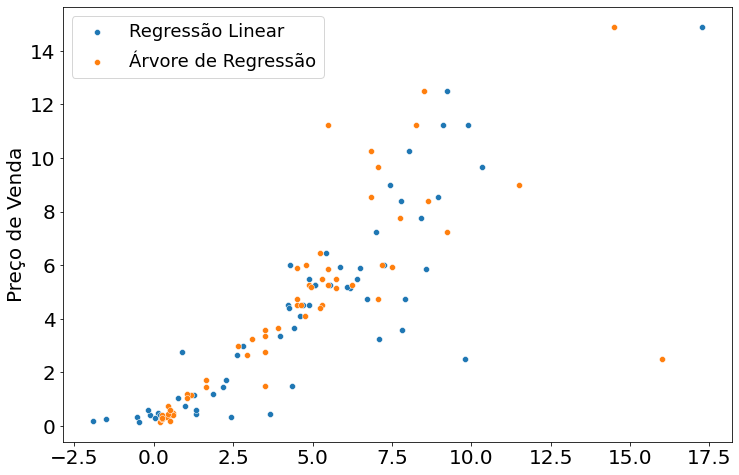

In [13]:
pred_linear = (best_model_linear.predict(x_test).reshape(61))
pred_tree = (best_model_tree.predict(x_test).reshape(61))

plt.figure(figsize=(12,8))
sns.scatterplot(x=pred_linear, y=y_test, label='Regressão Linear')
sns.scatterplot(x=pred_tree, y=y_test, label='Árvore de Regressão')
plt.legend(prop={'size' : 18})
plt.ylabel('Preço de Venda', size=20);